In [1]:
!pip install finance-datareader

In [2]:
!pip install plotly

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

import torch
import torch.nn as nn

In [4]:
data = fdr.DataReader("005930") # 삼성전자 주식
data.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2000-04-21,6060,6180,5970,6050,528513,NaN
2000-04-24,5970,6030,5760,5800,556613,-0.041322
2000-04-25,5620,5760,5520,5640,698014,-0.027586
2000-04-26,5820,5860,5600,5600,785860,-0.007092
2000-04-27,5520,5700,5400,5400,1082253,-0.035714


In [5]:
data = data[["Close"]] # dataframe으로 만들려면 [] 두번감싸야함 ([] 한번만감싸면 시리즈로 나옴) # 종가만 보겠다
data

,Close
Date,
2000-04-21,6050
2000-04-24,5800
2000-04-25,5640
2000-04-26,5600
2000-04-27,5400
...,...
2024-08-05,71400
2024-08-06,72500
2024-08-07,74700


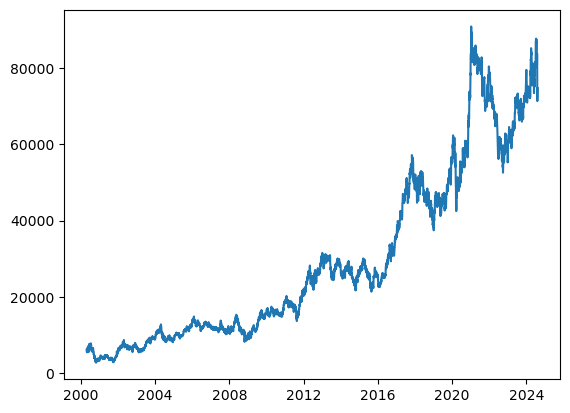

In [6]:
plt.plot(data)

## 딥러닝 전용으로 코드작성
- Close(종가)의 추세를 반영해서 Close값 예측하고자 함

In [7]:
from copy import deepcopy as dc

# lstm을 위해 dataframe을 준비하는 함수를 만듦 (원데이터가 추세(ex.시계열?)를 따르도록) => 조작적정의 (원데이터에 기반한)
# pandas에서 제공하는 "차분"메서드 : shift() , pct_change(), diff(), rolling(), resample() 등등 사용
# https://jhy156456.tistory.com/entry/python-shift-pctchange-diff-rolling-resample
def prepare_dataframe_for_lstm(df, n_steps): 
    df = dc(df)
    for i in range(1,n_steps+1):
        df[f"Close(t-{i})"] = df["Close"].shift(i) # shift : 하나씩 뒤로 옮겨서 추세를 따르도록함
    df.dropna(inplace=True)
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2000-05-03,6180,6280.0,6000.0,5400.0,5600.0,5640.0,5800.0,6050.0
2000-05-04,6180,6180.0,6280.0,6000.0,5400.0,5600.0,5640.0,5800.0
2000-05-08,6560,6180.0,6180.0,6280.0,6000.0,5400.0,5600.0,5640.0
2000-05-09,6370,6560.0,6180.0,6180.0,6280.0,6000.0,5400.0,5600.0
2000-05-10,6350,6370.0,6560.0,6180.0,6180.0,6280.0,6000.0,5400.0
...,...,...,...,...,...,...,...,...
2024-08-05,71400,79600.0,83100.0,83900.0,81000.0,81200.0,80900.0,80400.0
2024-08-06,72500,71400.0,79600.0,83100.0,83900.0,81000.0,81200.0,80900.0
2024-08-07,74700,72500.0,71400.0,79600.0,83100.0,83900.0,81000.0,81200.0


In [8]:
# 넘파이 데이터로 바꿔줘야함, 몇개인지 확인
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np.shape

(5993, 8)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

In [10]:
# X,y 나누기
X = shifted_df_as_np[:,1:]
y = shifted_df_as_np[:,0]
print(X.shape, y.shape)

(5993, 7) (5993,)


In [11]:
X[0] # t1,t2,t3,... 값

array([-0.91956497, -0.92590914, -0.9395038 , -0.93497224, -0.93406593,
       -0.93044069, -0.92477625])

In [12]:
np.flip(X, axis=1) # flip : 뒤집는거 (추세를 따르지 못함->뒤집어줘야함)

array([[-0.92477625, -0.93044069, -0.93406593, ..., -0.9395038 ,
        -0.92590914, -0.91956497],
       [-0.93044069, -0.93406593, -0.93497224, ..., -0.92590914,
        -0.91956497, -0.92183075],
       [-0.93406593, -0.93497224, -0.9395038 , ..., -0.91956497,
        -0.92183075, -0.92183075],
       ...,
       [ 0.777954  ,  0.77342245,  0.83912994, ...,  0.7417016 ,
         0.55590801,  0.58083154],
       [ 0.77342245,  0.83912994,  0.82100374, ...,  0.55590801,
         0.58083154,  0.6306786 ],
       [ 0.83912994,  0.82100374,  0.7417016 , ...,  0.58083154,
         0.6306786 ,  0.60122352]])

In [13]:
X = dc(np.flip(X, axis=1))

In [14]:
split_index = int(len(X)*0.95)
split_index

5693

## Train and Test
- batch_fist = True

In [15]:
# X_train = X[:split_index]
# X_test = X[split_index:]
# y_train = y[:split_index]
# y_test = y[split_index]

In [16]:
# print(X_train.shape, X_test.shape) # 이렇게하면 오류남 (튜플세개 필요) : batch_first

In [17]:
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

X_train = X_train.reshape((-1, lookback, 1)) # lookback 7칸씩 보는것
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1)) # lookback 7칸씩 보는것 빼줘야함
y_test = y_test.reshape((-1, 1))

In [18]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) # lstm 쓰려면 batch_first = True해서 이런 형태로 만들어줘야함

(5693, 7, 1) (300, 7, 1) (5693, 1) (300, 1)


In [19]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

In [20]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([5693, 7, 1]) torch.Size([300, 7, 1]) torch.Size([5693, 1]) torch.Size([300, 1])


In [21]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [22]:
from torch.utils.data import DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0], batch[1]
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [24]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size,1)
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        out, _ = self.lstm(x,(h0,c0))
        out = self.fc(out[:,-1,:]) # :은 전부다 쓰도록 / 중간은 알아서 채워넣도록
        return out
model = LSTM(1,4,1)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [25]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
def train_one_epoch():
    model.train(True)
    running_loss = 0.0
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0], batch[1]
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss/100
            print(f"{batch_index+1}, {avg_loss_across_batches}")
            running_loss = 0.0
    print()

In [27]:
for epoch in range(num_epochs):
    train_one_epoch()

100, 0.3416797237098217
200, 0.08126045022159815
300, 0.013519509953912347

100, 0.004978812763001769
200, 0.003984837307943963
300, 0.0032025444897590205

100, 0.0027123948413645847
200, 0.002319671490113251
300, 0.0020634204969974235

100, 0.0016197442851262167
200, 0.0014104998714174143
300, 0.0011032571489340626

100, 0.0009662729562842287
200, 0.0007731722827884369
300, 0.0007283642567927018

100, 0.0005610495778091717
200, 0.0005371301098784898
300, 0.0005197781573224347

100, 0.0003733770405960968
200, 0.00042154404560278635
300, 0.0003124742970248917

100, 0.0003552579820825486
200, 0.0002688340920576593
300, 0.000295096333429683

100, 0.0003082415850440157
200, 0.0002977537395054242
300, 0.0002389705513633089

100, 0.0002801777111017145
200, 0.0002474503065968747
300, 0.00027084615543572



In [31]:
# 검증코드

def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0], batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [30]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

100, 0.0002828002953901887
200, 0.00021828074430231935
300, 0.0003044754664733773



NameError: name 'device' is not defined

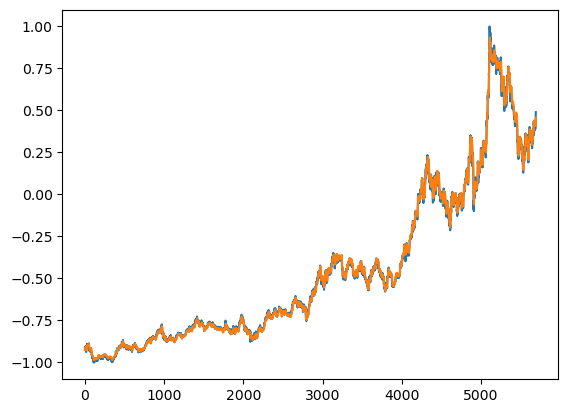

In [29]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

# 과대적합